# Распознавание объектов по цвету
Работа выполнена в рамках лабораторной работы по дисциплине Цифровая обработка изображений.

Задание на лабораторную работу заключается в приведении изображения из RGB в цветовое пространство по варианту (в моём случае - это CMYK) с последующей реализацией классификатора.

В данной работе используется датасет Food-101:
* https://www.kaggle.com/datasets/dansbecker/food-101?select=food-101.zip

# 1. Чтение данных
Структура папки датасета следующая:
* pec/
    * images/
        * \<class_name>/
            * \<image_id>.jpg
    * meta/
        * classes.txt
        * labels.txt
        * test.json
        * test.txt
        * train.json
        * train.txt

In [19]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import Accuracy, StatScores
from torch.optim import SGD
from torchinfo import summary

import json
from pathlib import Path
from PIL import Image

import random
from itertools import chain
import requests, zipfile, io

import matplotlib.pyplot as plt

import time
from tqdm.auto import tqdm

## 1.1. Определение путей до файлов

In [2]:
# Адрес датасета
path_dataset = Path("./data/L2/food-101/food-101")

# Адреса изображений и метаданных
path_data    = path_dataset / "images"
path_meta    = path_dataset / "meta"

# Все классы перечислены по следующему пути
path_classes = path_meta / "classes.txt"

# Разбивка по выборкам определена в двух файлах JSON
path_json_train = path_meta / "train.json"
path_json_test  = path_meta / "test.json"

print(
    f"Пути до файлов:\n"
    f"  Папка датасета: {path_dataset}\n"
    f"    Папка данных:     {path_data}\n"
    f"    Папка метаданных: {path_meta}\n"
    f"      Список классов:                {path_classes}\n"
    f"      Список меток для обучения:     {path_json_train}\n"
    f"      Список меток для тестирования: {path_json_test}"
)

Пути до файлов:
  Папка датасета: data\L2\food-101\food-101
    Папка данных:     data\L2\food-101\food-101\images
    Папка метаданных: data\L2\food-101\food-101\meta
      Список классов:                data\L2\food-101\food-101\meta\classes.txt
      Список меток для обучения:     data\L2\food-101\food-101\meta\train.json
      Список меток для тестирования: data\L2\food-101\food-101\meta\test.json


## 1.2. Определение списка классов
В датасете есть довольно большое количество классов изображений. Выберем из них только ограниченное количество.

In [3]:
NUM_CLASSES = 5
all_classes = []

random.seed(42)

with path_classes.open() as f:
    for line in f:
        all_classes.append(line[:-1])

classes = random.sample(all_classes, NUM_CLASSES)
print(f"{NUM_CLASSES} случайных классов из {len(all_classes)} изначальных: {classes}")

5 случайных классов из 101 изначальных: ['ramen', 'carrot_cake', 'beef_carpaccio', 'strawberry_shortcake', 'escargots']


## 1.3. Чтение изображений определённых классов
Создадим словарь формата:

`{<имя-класса> : [список элементов формата: (<id-изображения>, <изображение>)]}`

In [4]:
images_original_dict = {}

for img_class in classes:
    path = path_data / img_class
    images_original_dict[img_class] = []
    for img_path in path.iterdir():
        if img_path.is_dir(): continue
        with Image.open(img_path) as img:
            idx = int(img_path.name[:-4])
            images_original_dict[img_class].append((idx, img.copy()))

In [5]:
print(f"Количество изображений в каждом классе:")
for img_class in images_original_dict:
    print(f"Класс: {img_class:>{max([len(el) for el in all_classes])}} | Количество изображений: {len(images_original_dict[img_class]):>5}")

Количество изображений в каждом классе:
Класс:                   ramen | Количество изображений:  1000
Класс:             carrot_cake | Количество изображений:  1000
Класс:          beef_carpaccio | Количество изображений:  1000
Класс:    strawberry_shortcake | Количество изображений:  1000
Класс:               escargots | Количество изображений:  1000


## 1.4. Преобразование из RGB в CMYK
Преобразование в соответствии с вариантом.

In [6]:
def RGB_to_CMYK(img: Image, scale=255):
    transform_matrix = np.array([
        [-1, 0, 0], # Cyan
        [0, -1, 0], # Magenta
        [0, 0, -1], # Yellow
        [0, 0, 0], # Black
    ]).T
    
    res = np.array(img).dot(transform_matrix) + scale
    min_cmy = np.expand_dims(res.min(axis=2), 2)
    res -= min_cmy
    scale_factor = scale - min_cmy
    scale_factor[scale_factor == 0] = scale
    res = np.round(res * (scale / (scale_factor)))
    res[:, :, 3] = min_cmy[:, :, 0]

    return Image.fromarray(res.astype(np.uint8), mode='CMYK')

In [7]:
images_CMYK_dict = {}
for img_class in images_original_dict:
    images_CMYK_dict[img_class] = []
    for idx, img in images_original_dict[img_class]:
        images_CMYK_dict[img_class].append((idx, RGB_to_CMYK(img)))

## 1.5. разделение на выборки
Само разделение описано в файлах метаданных формата JSON, однако надо провести несколько манипуляций, чтобы разделить непосредственно данные на выборки.

In [8]:
all_train_dict = None
all_test_dict  = None

# Прочитаем файл выборки обучения
with open(path_json_train) as f:
    all_train_dict = json.load(f)

# Прочитаем файл выборки теста
with open(path_json_test) as f:
    all_test_dict = json.load(f)

Отсечём всё лишнее и приведём типы id к типу `int`.

Формат словаря следующий:
* Словарь {<класс> : список [идентификатор типа int]}

In [9]:
# Инициализируем словари разделения выборок
dict_train = {}
dict_test  = {}

# И заполним их
for img_class in classes:
    dict_train[img_class] = []
    dict_test[img_class]  = []

    # Сначала заполним индексы для обучающей выборки
    for raw_id in all_train_dict[img_class]:
        idx = int(raw_id.split('/')[1])
        dict_train[img_class].append(idx)
    
    # А теперь - для тестовой выборки
    for raw_id in all_test_dict[img_class]:
        idx = int(raw_id.split('/')[1])
        dict_test[img_class].append(idx)

Теперь сформируем выборки.

Проведём несколько операций:
1. Сделаем отображение формата `{<имя-класса> : <метка-класса>}` и наоборот;
2. В соответствии с отображением сформируем списки данных и меток для обучающей и тестовой выборок.

In [10]:
class_names = {}
class_idxes = {}

for idx, class_name in enumerate(classes):
    class_names[idx] = class_name
    class_idxes[class_name] = idx

class_names, class_idxes

({0: 'ramen',
  1: 'carrot_cake',
  2: 'beef_carpaccio',
  3: 'strawberry_shortcake',
  4: 'escargots'},
 {'ramen': 0,
  'carrot_cake': 1,
  'beef_carpaccio': 2,
  'strawberry_shortcake': 3,
  'escargots': 4})

In [11]:
def to_tensor(img : Image) -> torch.Tensor:
    return torch.tensor(np.array(img).transpose(2, 0, 1))

In [12]:
X_train, X_test = [], []
y_train, y_test = [], []

for class_name in classes:
    for idx, img in images_CMYK_dict[class_name]:
        if idx in dict_train[class_name]:
            X_train.append(to_tensor(img))
            y_train.append(class_idxes[class_name])
        if idx in dict_test[class_name]:
            X_test.append(to_tensor(img))
            y_test.append(class_idxes[class_name])

print(f"Размер обучающей выборки: (Данные: {len(X_train)}, Метки: {len(y_train)})")
print(f"Размер тестовой выборки:  (Данные: {len(X_test)}, Метки: {len(y_test)})")

Размер обучающей выборки: (Данные: 3750, Метки: 3750)
Размер тестовой выборки:  (Данные: 1250, Метки: 1250)


# 2. Анализ датасета
## 2.1 Просмотр распределения по цветам для каждого класса

In [13]:
colors_dict = {}
color_names = ['cyan', 'magenta', 'yellow', 'black']

for class_name in classes:
    colors_dict[class_name] = {}
    for cid, color in enumerate(color_names):
        color_counts = pd.Series(np.zeros(256))
    
        for idx, img in images_CMYK_dict[class_name]:
            values, counts = np.unique(np.array(img)[:, :, cid], return_counts=True)
            color_counts = color_counts.add(pd.Series(counts, values), fill_value=0)
        
        colors_dict[class_name][color] = color_counts

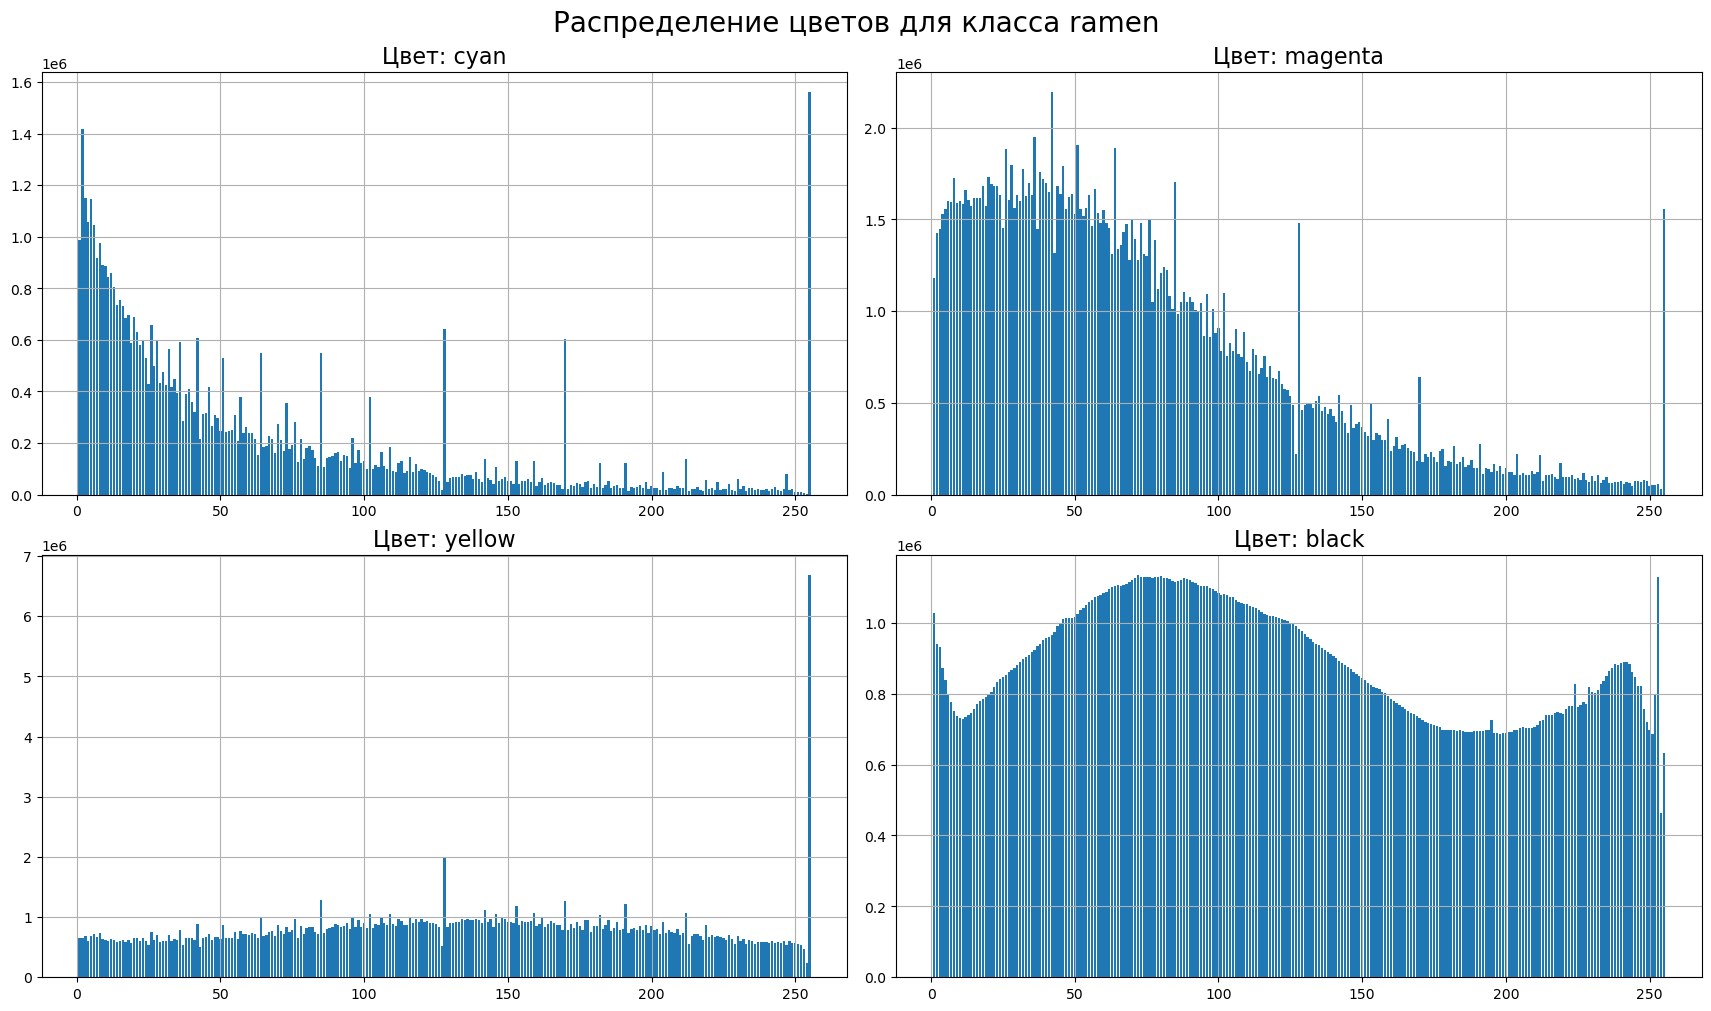

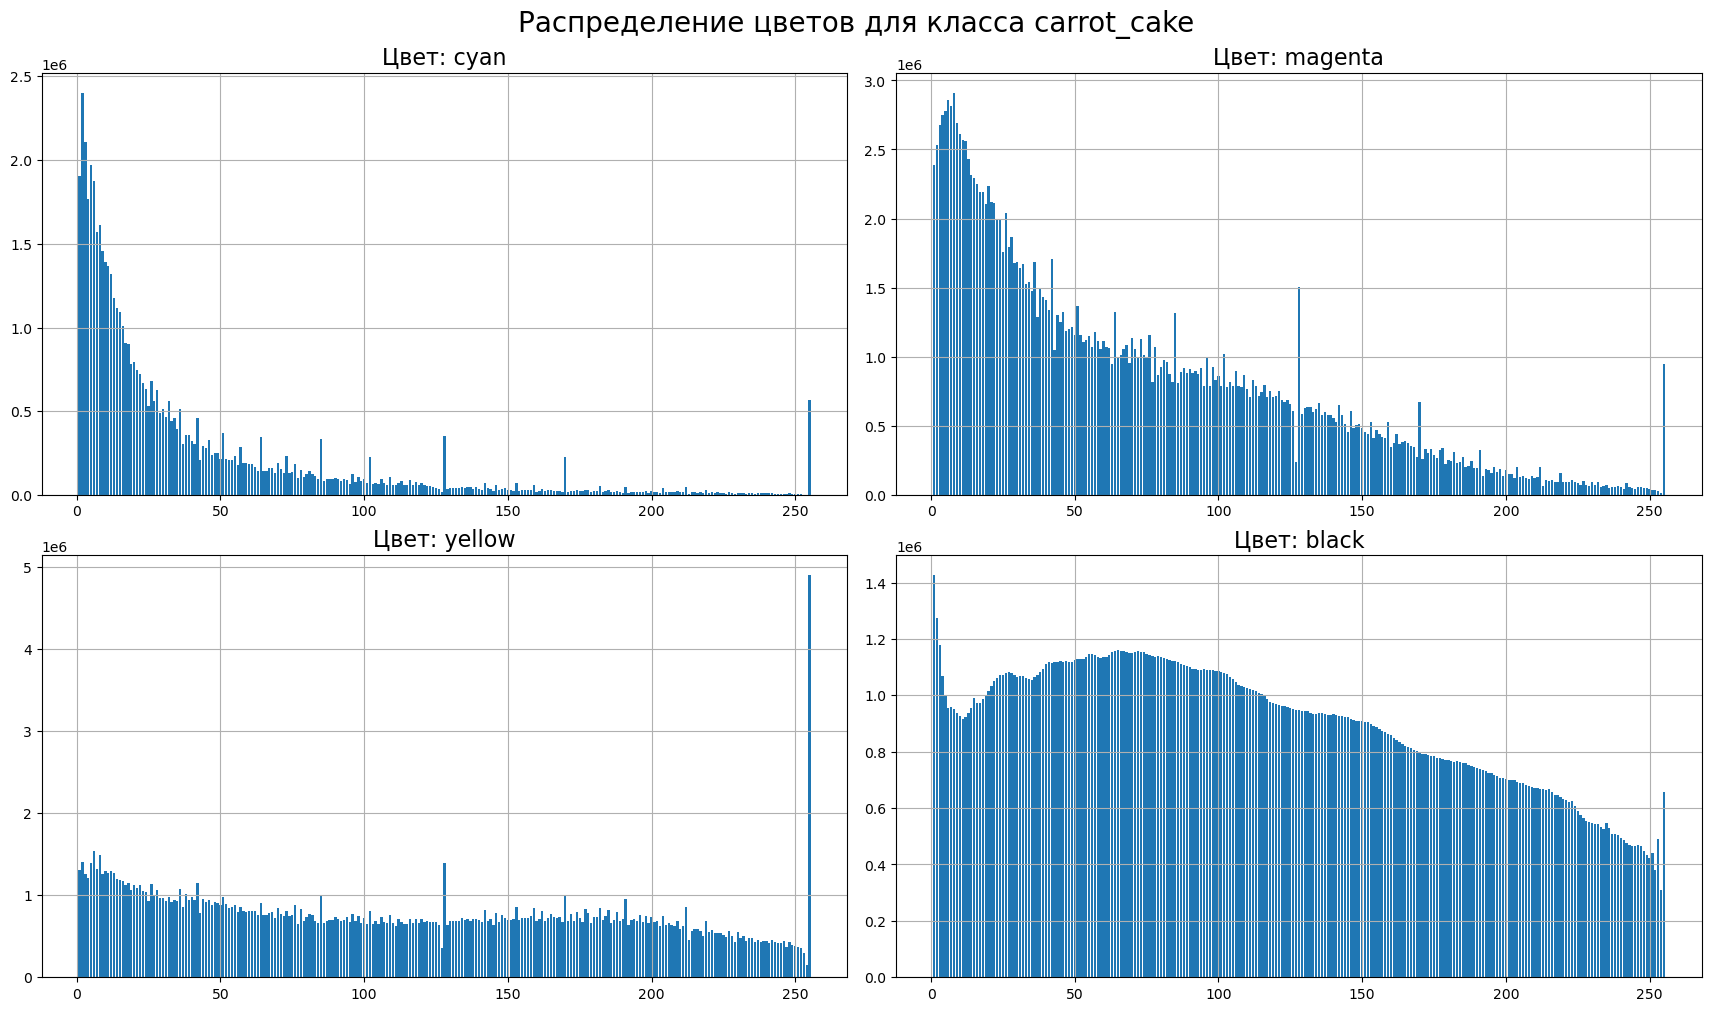

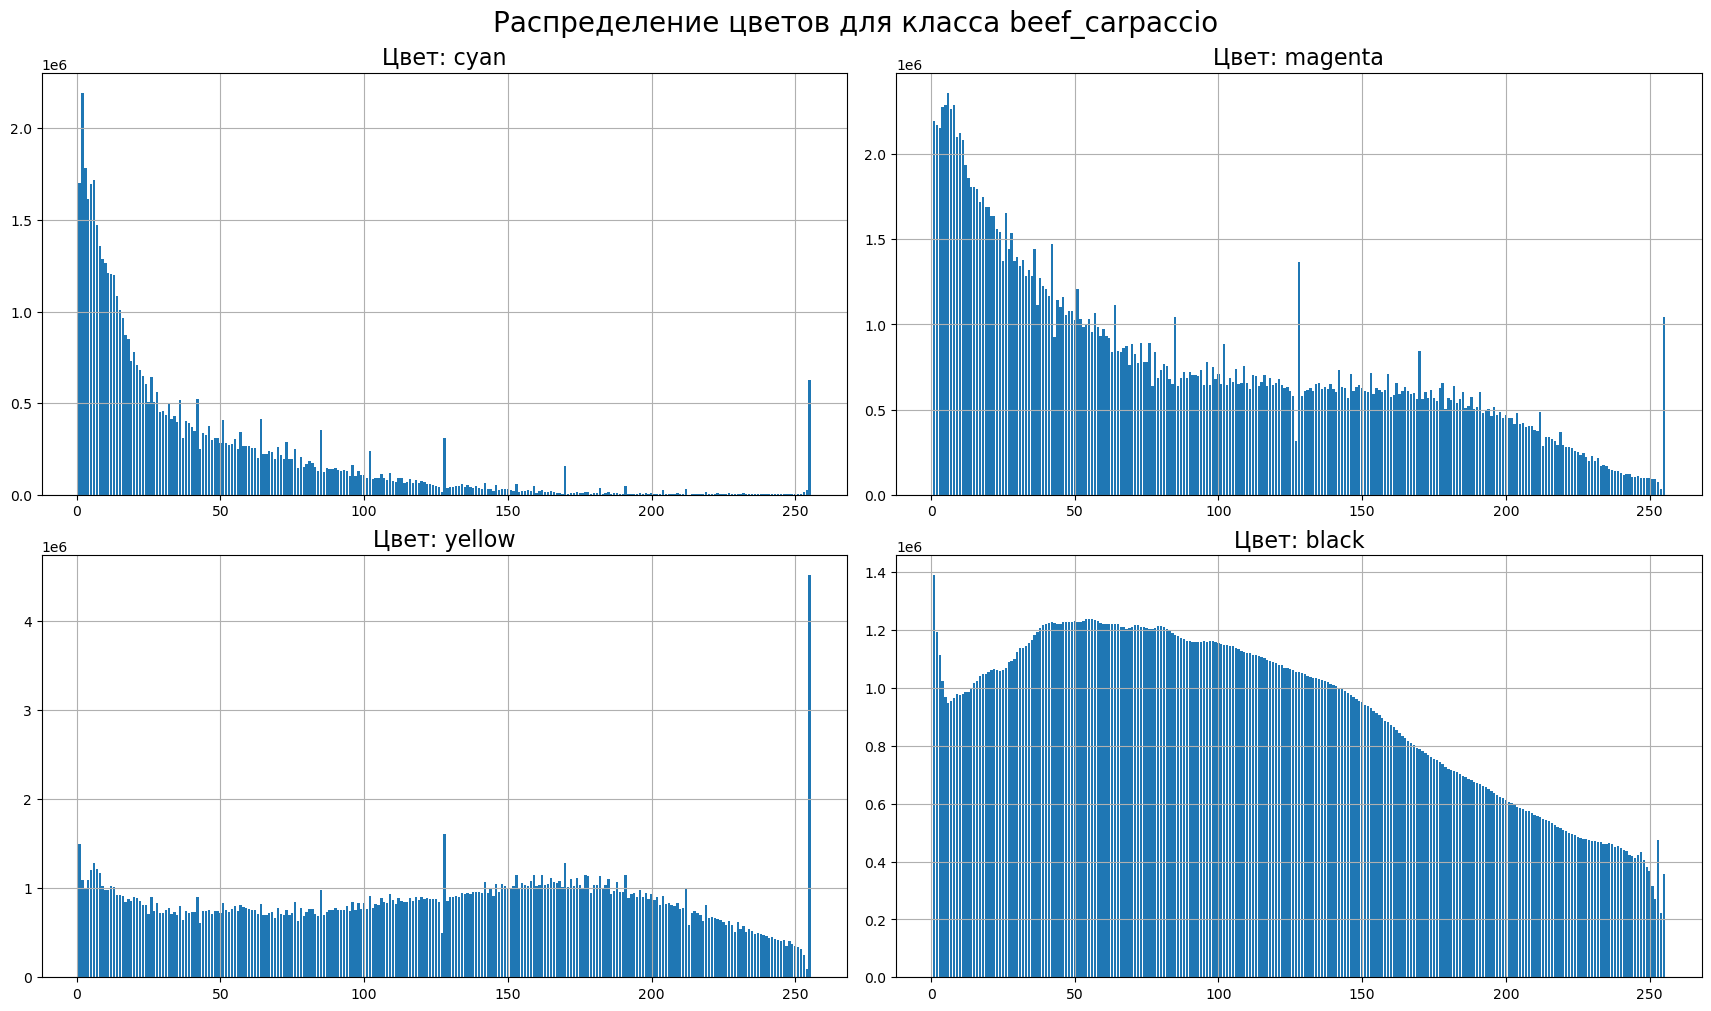

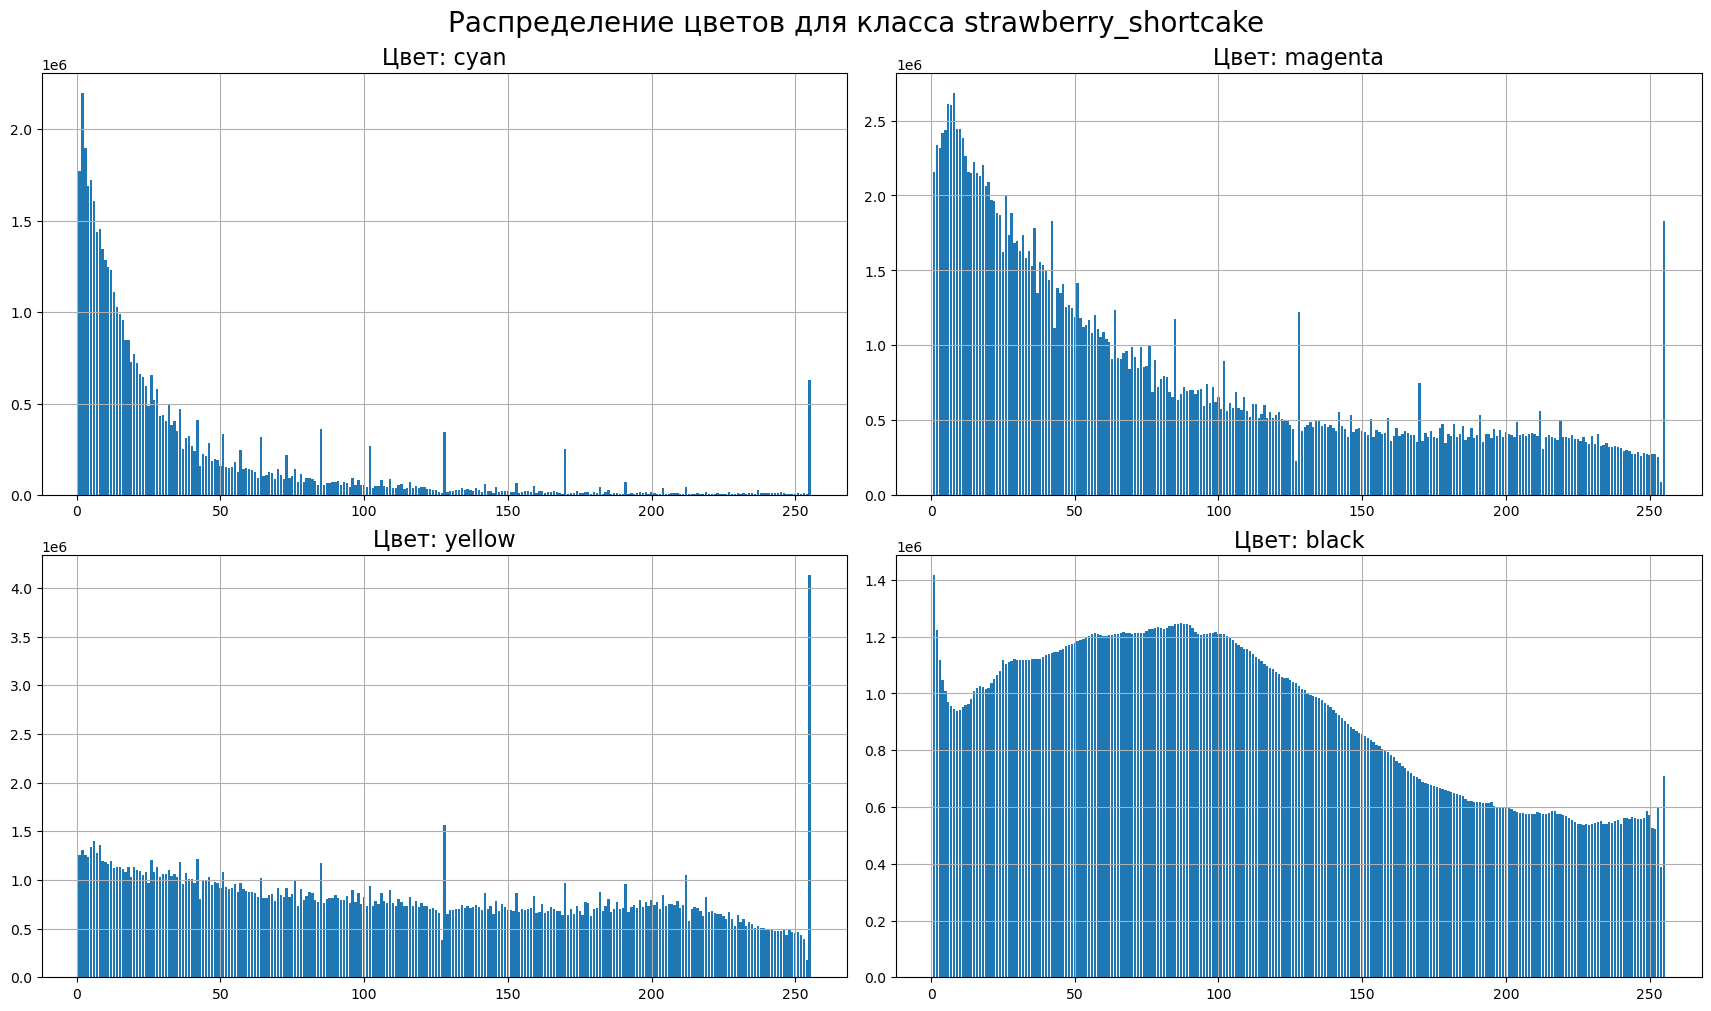

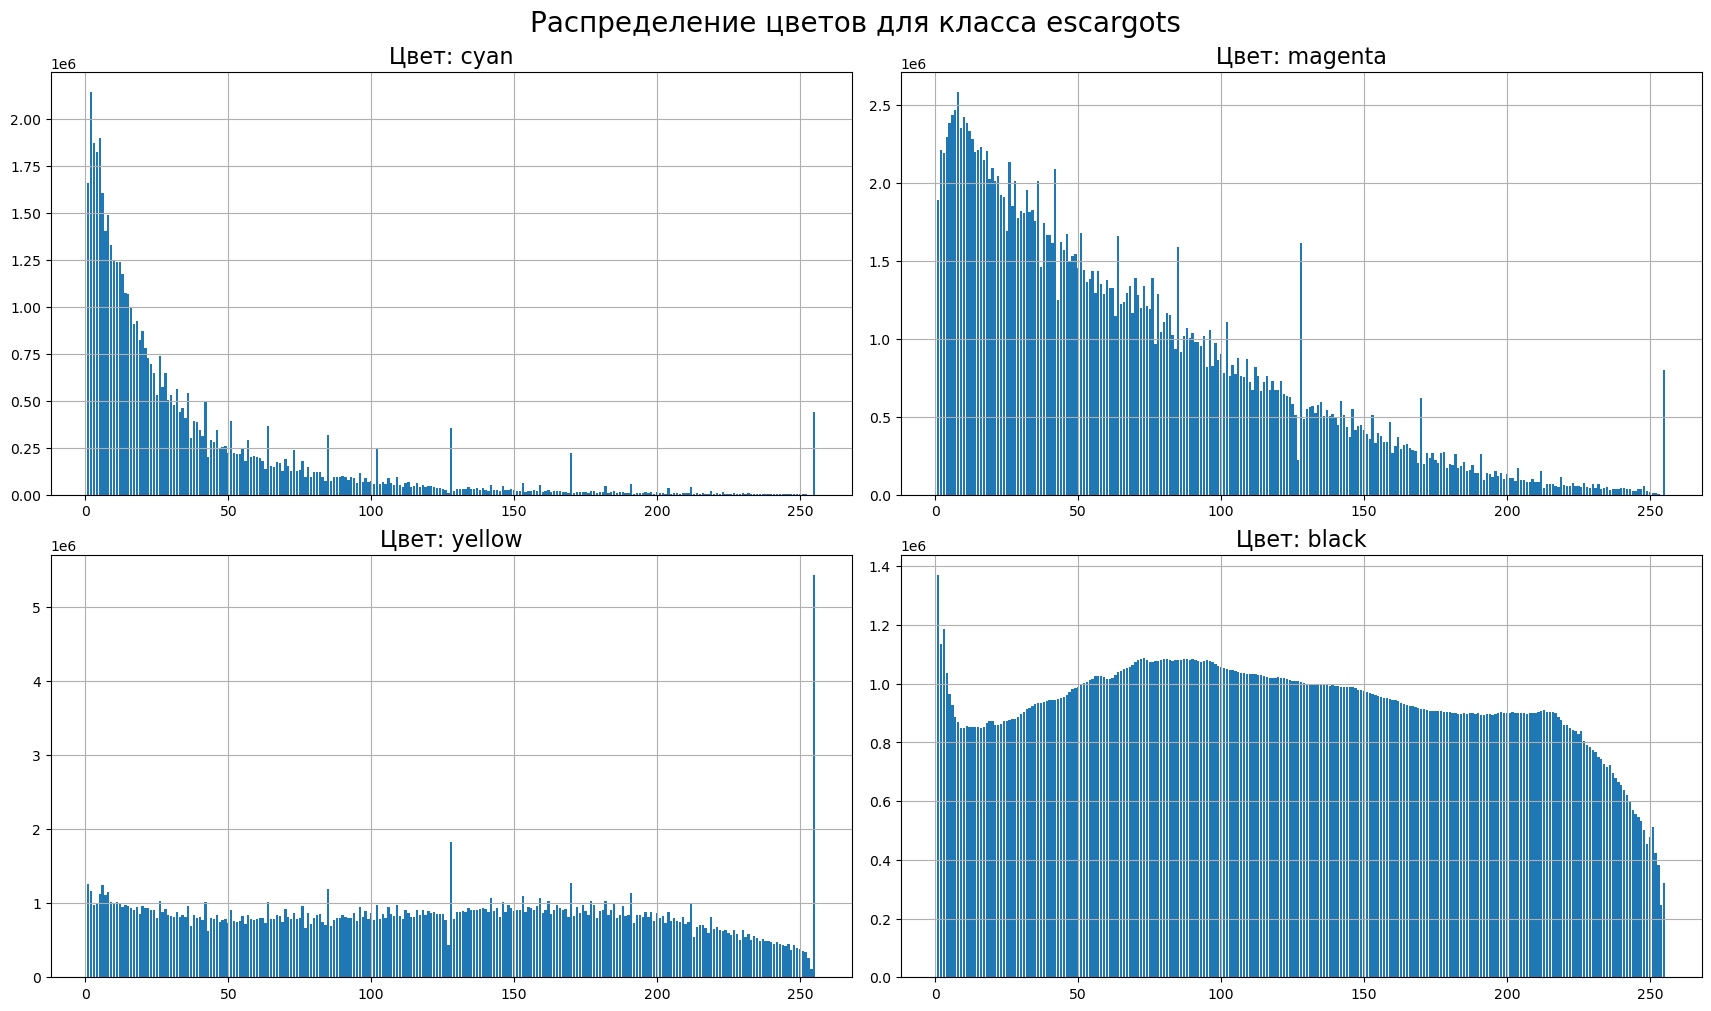

In [14]:
for class_name in classes:
    colors = colors_dict[class_name]
    
    fig, axes = plt.subplots(2, 2, figsize=(17, 10), layout='constrained')
    fig.suptitle(f"Распределение цветов для класса {class_name}", fontsize=20)

    for ax, color in zip(chain.from_iterable(axes), color_names):
        # В силу специфики CMYK нули преобладают, поэтому имеет смысл их отбростить
        color_counts = colors[color][1:]
        ax.bar(color_counts.index, color_counts)
        ax.set_title(f"Цвет: {color}", fontsize=16)
        ax.grid()

# 3. Предобработка изображения
В данном разделе потребуется привести данные к формату, поддерживаемому библиотекой pytorch.

## 3.1. Обработка размеров изображений
Для начала, следует узнать размеры изображений в выборках. Нас интересуют нижние значения, чтобы привести к ним все изображеия. Нужно это по той причине, что вход нейронной сети будет ограничен этими значениями.

In [15]:
min_height, min_width = 512, 512

for class_name in images_CMYK_dict:
    for _, img in images_CMYK_dict[class_name]:
        height = img.height
        width  = img.width
    
        if height < min_height: min_height = height
        if width  < min_width:  min_width  = width

min_shape = (min_height, min_width)
print(f"Минимальные размер изображения: {min_shape}.")

Минимальные размер изображения: (222, 223).


In [16]:
# Определим новые размеры изображений, основываясь на минимальных.
# Сделаем их кратными 32.
eval_shape = min_height - min_height % 32, min_width - min_width % 32
print(f"Размеры изображения на входе нейронной сети будут: {eval_shape}.")

Размеры изображения на входе нейронной сети будут: (192, 192).


Но это слишком большая размерность для моей системы, так что оганичимся (64х64).

In [17]:
eval_shape = (64, 64)

## 3.2. Инициализация преобразований
Определим преобразования в соотвии со всем описанным ниже. В этих целях используем преобразования из библиотеки `torchvision`.

In [18]:
trans = transforms.Resize(eval_shape)

## 3.3. Создание датасетов

Теперь создадиим датасеты для взаимодействия с библиотекой pytorch. Так как данным нужны дополнительные преобазования, то удобно будет сделать свой класс датасета.

Также считаю интересным попробовать в качестве входных данных использовать распределение цветов на изображении. Для этого сделаем ещё одну модель.

### 3.3.1. Классический датасет для свёрточной нейронной сети

In [19]:
class TransformedDataset(Dataset):
    def __init__(self, X, y, transform=None):
        super().__init__()
        assert len(X) == len(y), f"Длины должны совпадать. Передано X:{len(X)}, y:{len(y)}."
        if transform is None:
            self.X = X.type(torch.float)
        else:
            self.X = torch.tensor(np.array([transform(x) for x in X])).type(torch.float)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index: int):
        return self.X[index], self.y[index]

In [20]:
train_dataset = TransformedDataset(
    X_train,
    y_train,
    transform=trans
)
test_dataset = TransformedDataset(
    X_test,
    y_test,
    transform=trans
)

### 3.3.2. Датасет с распределением цветов на изображении

In [21]:
class ColorDataset(Dataset):
    def __init__(self, X, y, scale=256):
        super().__init__()
        assert len(X) == len(y), f"Длины должны совпадать. Передано X:{len(X)}, y:{len(y)}."
        self.y = torch.tensor(y)
        self.scale = scale
        self.X = torch.tensor(np.array([self.get_colors_distribution(x) for x in X]))

    def get_colors_distribution(self, x:torch.Tensor) -> torch.Tensor:
        res = torch.zeros((x.size()[0], self.scale))
        for channel, vals in enumerate(x):
            res[channel] = torch.bincount(vals.flatten(), minlength=self.scale)
        return res

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index:int):
        return self.X[index], self.y[index]

In [22]:
train_dataset_colors = ColorDataset(
    X_train,
    y_train,
)
test_dataset_colors = ColorDataset(
    X_test,
    y_test,
)

## 3.4. Инициализация загрузчиков данных
Здесь же определяется расмер одной пачки (batch) данных.

In [23]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

train_dataloader_colors = DataLoader(
    train_dataset_colors,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
test_dataloader_colors = DataLoader(
    test_dataset_colors,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True
)

# 4. Обучение модели
В данном разделе создадим модель и обучим её.

## 4.1. Определение устройства вычислений
Для начала, следует определить устройство вычислений.

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Устройство: {device}.")
if device == 'cuda':
    !nvidia-smi

Устройство: cuda.
Sat Apr 13 11:03:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   39C    P8              9W /  170W |     582MiB /  12288MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------

## 4.2. Создание моделей
Здесь создадим обе модели.

### 4.2.1. Создание модели свёрточной нейронной сети
Модель представляет собой свёрточную нейронную сеть следующей архитектуры:
1. Свёрточный слой (входные каналы: 4 (CMYK), выходные каналы: 10, размер фильтра: 5, шаг: 1, паддинг: 2);
2. ReLu;
3. Слой пуллинга (размер фильтра: 2, шаг: 2);
4. Свёрточный слой (10, 15, 3, 1, 1);
5. ReLU;
6. Слой пуллинга (2, 2);
7. Слой "выпрямителя" (перевод в одноразмерный массив);
8. Полносвязный слой (вход: 192 * 192 * 15 / 16, выход: 1000);
9. ReLU;
10. Полносвязный слой (вход: 1000, выход: 5).

In [25]:
class CNNModel(nn.Module):
    def __init__(self, in_shape, classes_num):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(4, 10, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(10, 15, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_shape[0] * in_shape[1] * 15 // 16, 1000),
            nn.ReLU(),
            nn.Linear(1000, classes_num)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(self.conv_2(self.conv_1(x)))

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_cnn = CNNModel(eval_shape, len(classes)).to(device)
model_cnn

CNNModel(
  (conv_1): Sequential(
    (0): Conv2d(4, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3840, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=5, bias=True)
  )
)

In [26]:
summary(model_cnn, input_size=[BATCH_SIZE, *list(train_dataset.X[0].size())])

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 5]                   --
├─Sequential: 1-1                        [32, 10, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 10, 64, 64]          1,010
│    └─ReLU: 2-2                         [32, 10, 64, 64]          --
│    └─MaxPool2d: 2-3                    [32, 10, 32, 32]          --
├─Sequential: 1-2                        [32, 15, 16, 16]          --
│    └─Conv2d: 2-4                       [32, 15, 32, 32]          1,365
│    └─ReLU: 2-5                         [32, 15, 32, 32]          --
│    └─MaxPool2d: 2-6                    [32, 15, 16, 16]          --
├─Sequential: 1-3                        [32, 5]                   --
│    └─Flatten: 2-7                      [32, 3840]                --
│    └─Linear: 2-8                       [32, 1000]                3,841,000
│    └─ReLU: 2-9                         [32, 1000]                --
│ 

### 4.2.2. Создание модели для цветов
Модель представляет собой обычную нейронную сеть с полносвязными слоями и имеет следующую архитектуру:
1. Слой "выпрямителя";
2. Полносвязный слой (вход: 4 * 256, выход: 10 000);
3. ReLU;
4. Полносвязный слой (вход: 10 000, выход: 1000);
5. ReLU;
6. Полносвязный слой (вход: 1000, выход: 5).

In [27]:
class ColorModel(nn.Module):
    def __init__(self, in_color_cannels, in_scale, classes_num):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_color_cannels * in_scale, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, classes_num)
        )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.network(x)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_color = ColorModel(4, 256, len(classes)).to(device)
model_color

ColorModel(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=1000, bias=True)
    (4): ReLU()
    (5): Linear(in_features=1000, out_features=5, bias=True)
  )
)

In [28]:
summary(model_color, input_size=[BATCH_SIZE, *list(train_dataset_colors.X[0].size())])

Layer (type:depth-idx)                   Output Shape              Param #
ColorModel                               [32, 5]                   --
├─Sequential: 1-1                        [32, 5]                   --
│    └─Flatten: 2-1                      [32, 1024]                --
│    └─Linear: 2-2                       [32, 1000]                1,025,000
│    └─ReLU: 2-3                         [32, 1000]                --
│    └─Linear: 2-4                       [32, 1000]                1,001,000
│    └─ReLU: 2-5                         [32, 1000]                --
│    └─Linear: 2-6                       [32, 5]                   5,005
Total params: 2,031,005
Trainable params: 2,031,005
Non-trainable params: 0
Total mult-adds (M): 64.99
Input size (MB): 0.13
Forward/backward pass size (MB): 0.51
Params size (MB): 8.12
Estimated Total Size (MB): 8.77

## 4.3. Процесс обучения моделей
В данном разделе непосредственно обучим модели.

In [29]:
def train_model(model:nn.Module,
                num_calsses:int,
                trainloader:DataLoader,
                testloader:DataLoader,
                device,
                epochs:int = 1000,
                lr=0.001,
                momentum=0.9):
    accuracy_fn   = Accuracy('multiclass', num_classes=len(classes)).to(device)
    statscores_fn = StatScores('multiclass', num_classes=len(classes)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr, momentum=momentum)
    
    report_epochs = epochs // 10
    if report_epochs == 0:
        report_epochs = epochs
    
    losses     = np.zeros(epochs)
    accuracies = np.zeros(epochs)
    statscores = np.zeros((epochs, 5))
    
    start_time = time.time()
    prev_time  = start_time
    
    for epoch in tqdm(range(epochs)):
        model.train()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            y_preds = model(inputs)
            loss = criterion(y_preds, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval()
        with torch.inference_mode():
            test_loss = 0
            accuracy  = 0
            statscore = torch.tensor([0, 0, 0, 0, 0]).to(device)
            
            for inputs, labels in testloader:
                test_inputs, test_outputs = inputs.to(device), labels.to(device)
                test_preds = model(test_inputs)
                test_labels = torch.argmax(test_preds, dim=1)

                test_loss += criterion(test_preds, test_outputs)
                accuracy  += accuracy_fn(test_labels, test_outputs)
                statscore += statscores_fn(test_labels, test_outputs)

            test_loss /= len(testloader)
            accuracy  /= len(testloader)
            
            losses[epoch]     = test_loss
            accuracies[epoch] = accuracy
            statscores[epoch] = statscore.cpu().numpy()

            # Остановить обучение, если началось переобучение
            if epoch >= 40 and np.mean(losses[epoch - 40 : epoch - 20]) < np.mean(losses[epoch - 20 : epoch]):
                current_time = time.time()
                
                losses     = losses[:epoch + 1]
                accuracies = accuracies[:epoch + 1]
                statscores = statscores[:epoch + 1]

                print(f"[Эпоха: {epoch + 1:4d}] Ошибка: {test_loss:.6f} | Точность: {accuracy * 100:9.6f} % "
                      f"| Время выполнения {(epoch + 1) % report_epochs:6d} эпох: {current_time - prev_time:11.6f} секунд")
                print(f"Обучение прервано по причине начала переобучения на {epoch + 1:6d} эпохе.")
                break
        
            if epoch % report_epochs == report_epochs - 1:
                current_time = time.time()
                print(f"[Эпоха: {epoch + 1:4d}] Ошибка: {test_loss:.6f} | Точность: {accuracy * 100:9.6f} % "
                      f"| Время выполнения {report_epochs:6d} эпох: {current_time - prev_time:11.6f} секунд")
                prev_time = current_time
    
    end_time = time.time()
    print(f"Итоговое время расчёта: {end_time - start_time:11.6f} секунд.")

    return (
        losses,
        accuracies,
        statscores
    )

### 4.3.1. Обучение модели свёрточной нейронной сети

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

losses_cnn, accuracies_cnn, statscores_cnn = train_model(
    model_cnn,
    len(classes),
    train_dataloader,
    test_dataloader,
    device,
    1000,
    lr=0.00001,
    momentum=0.5
)

  0%|          | 0/1000 [00:00<?, ?it/s]

[Эпоха:  100] Ошибка: 1.133798 | Точность: 54.246796 % | Время выполнения    100 эпох:   46.327731 секунд
[Эпоха:  150] Ошибка: 1.131132 | Точность: 56.730770 % | Время выполнения     50 эпох:   23.543283 секунд
Обучение прервано по причине начала переобучения на    150 эпохе.
Итоговое время расчёта:   69.872010 секунд.


In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

losses_color, accuracies_color, statscores_color = train_model(
    model_color,
    len(classes),
    train_dataloader_colors,
    test_dataloader_colors,
    device,
    100,
    lr=0.00001,
    momentum=0.5
)

  0%|          | 0/100 [00:00<?, ?it/s]

[Эпоха:   10] Ошибка: 2.943631 | Точность: 22.916668 % | Время выполнения     10 эпох:    2.702832 секунд
[Эпоха:   20] Ошибка: 2.861227 | Точность: 22.996796 % | Время выполнения     10 эпох:    2.808851 секунд
[Эпоха:   30] Ошибка: 2.956830 | Точность: 22.275642 % | Время выполнения     10 эпох:    2.820726 секунд
[Эпоха:   40] Ошибка: 2.972699 | Точность: 22.596153 % | Время выполнения     10 эпох:    2.828083 секунд
[Эпоха:   46] Ошибка: 3.011453 | Точность: 22.836538 % | Время выполнения      6 эпох:    1.701681 секунд
Обучение прервано по причине начала переобучения на     46 эпохе.
Итоговое время расчёта:   12.862174 секунд.


# 5. Результаты
Определим общую функцию для вывода результатов.

In [32]:
def plot_results(title:str, loss:np.ndarray, acc:np.ndarray, stats:np.ndarray):
    fig, axes = plt.subplots(2, 2, figsize=(15, 7), layout='constrained')
    epochs = loss.size

    plt.suptitle(title + '\n' + f"[Метрики за {epochs} эпох]")
    
    for axes_row in axes:
        for ax in axes_row:
            ax.set_xlabel("Эпоха")
            ax.grid()
    
    axes[0][0].plot(loss)
    axes[0][0].set_title("Функция потерь (Кросс-энтропия)")
    axes[0][0].set_ylabel("Ошибка")
    
    axes[0][1].plot(acc)
    axes[0][1].set_title("Точность")
    axes[0][1].set_ylabel("Точность")
    
    axes[1][0].plot(stats[:, 1])
    axes[1][0].set_title("Ошибка первого рода")
    axes[1][0].set_ylabel("Количество ложных срабатываний")
    
    axes[1][1].plot(stats[:, 3])
    axes[1][1].set_title("Ошибка второго рода")
    axes[1][1].set_ylabel("Количество ложных срабатываний")
    
    plt.show()

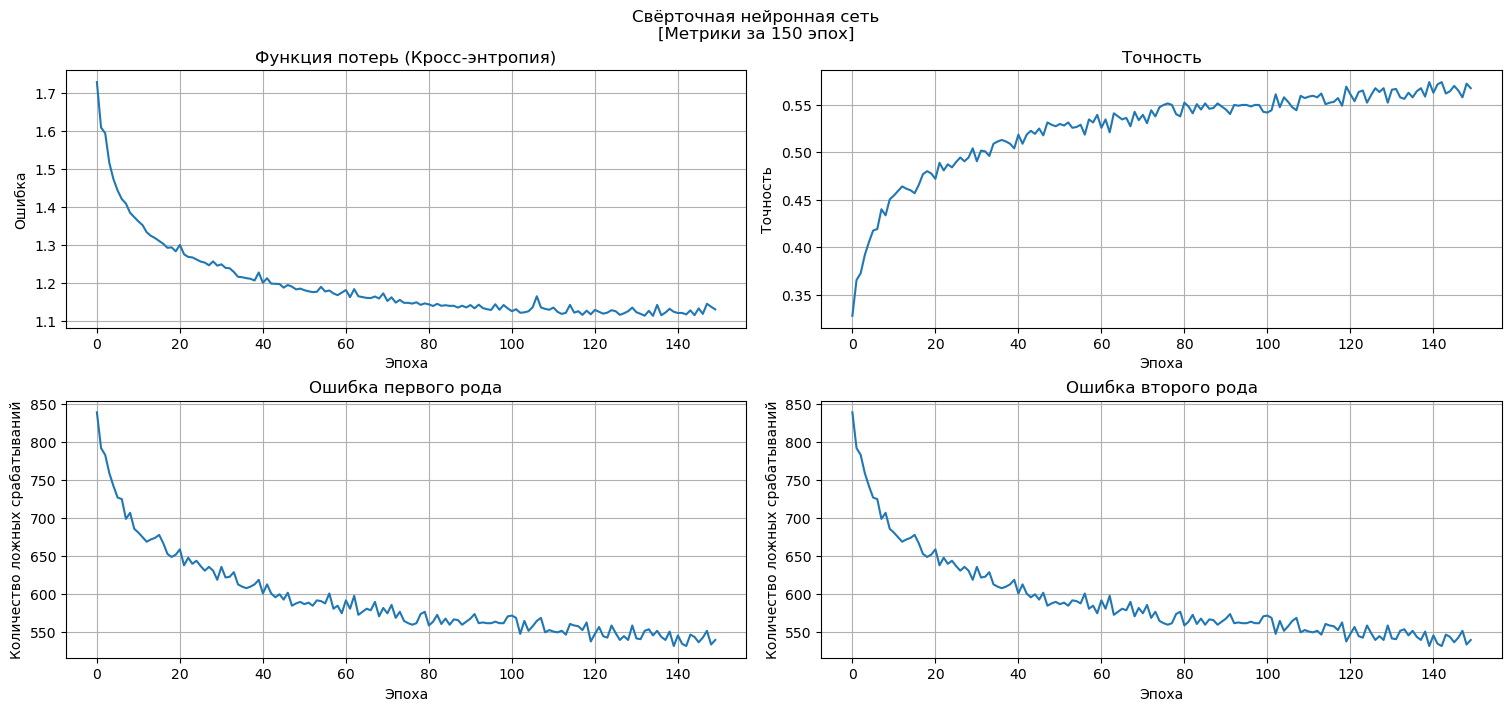

In [35]:
plot_results("Свёрточная нейронная сеть", losses_cnn, accuracies_cnn, statscores_cnn)

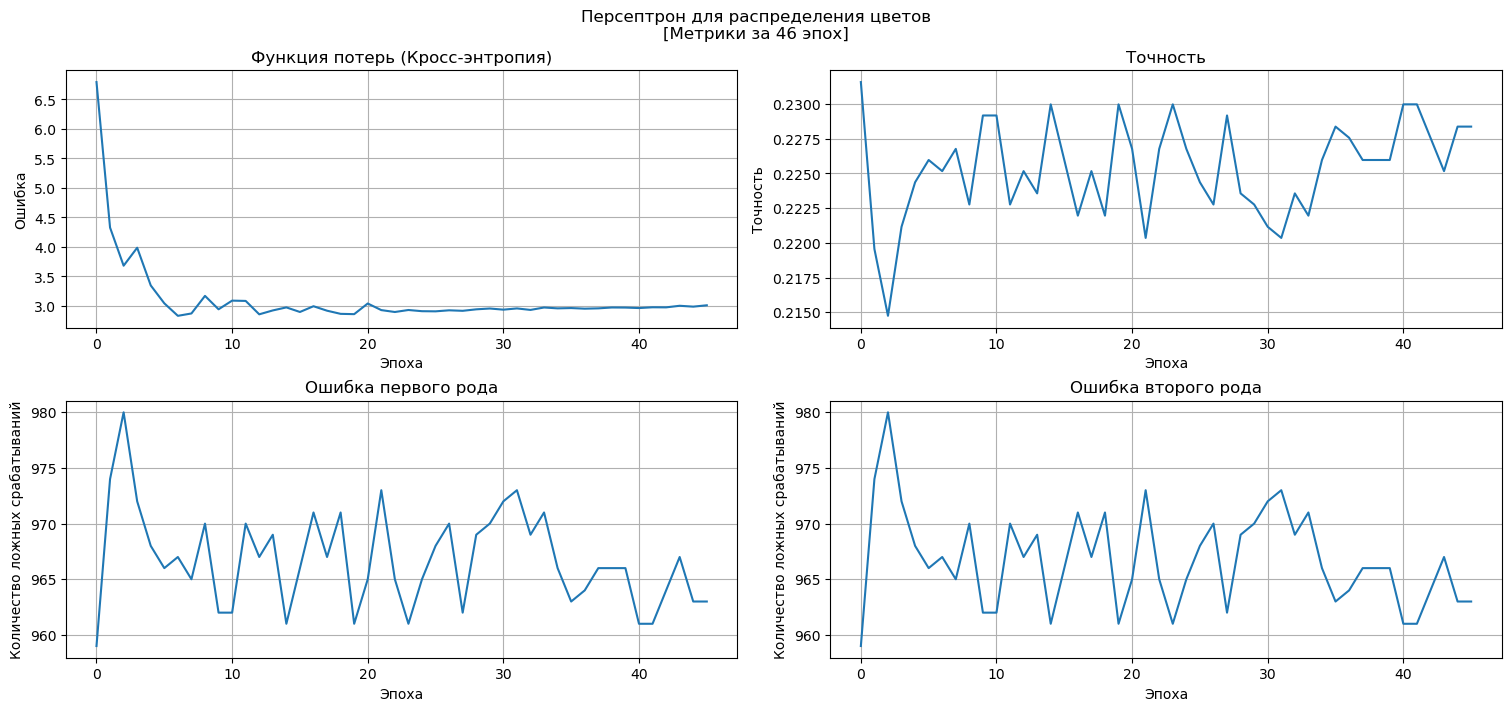

In [34]:
plot_results("Персептрон для распределения цветов", losses_color, accuracies_color, statscores_color)

Придётся признать, что эксперимент с распределением цветов скорее неудачный.